# Homework 2 Exercise 1
Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 dataset. The heights listed below were recorded in the !Kung census, but weights were not recorded for these individuals. Provide predicted weights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| Individual | height | expected weight  | 89% interval  |
|---|---|---|---|
| 1 | 140 |   |   |
| 2 | 160 |   |   |
| 3 | 175 |   |   |

In [70]:
using StatsPlots
using StatisticalRethinking: sr_datadir, PI
using StatisticalRethinkingCommon
using Statistics, StatsBase
import CSV
using DataFrames
using Gen, Distributions

In [71]:
@time data = CSV.read(sr_datadir("Howell1.csv"), DataFrame)

  0.000370 seconds (347 allocations: 46.938 KiB)


,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


In [72]:
adults = data[data.age .>= 18 , :]

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


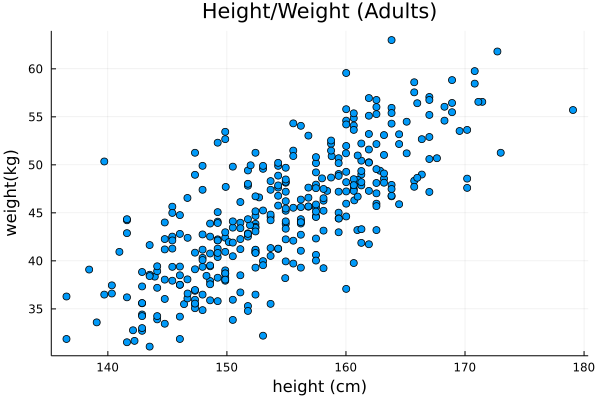

In [73]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm)", ylabel="weight(kg)", legend=false)

In [74]:
dt = standardize_column!(adults, :height, scale=false)

ZScoreTransform{Float64, Vector{Float64}}(1, 1, [154.59709261363633], Float64[])

In [75]:
@gen function adults_height_weight_model(heights)
    a ~ normal(40., 10.) # somewhere around 50, in kg
    b ~ gamma(1, 5) # how does weight scale with height, in kg/cm. However, don't forget that height was normalized.
    noise ~ gamma(1., 1.) # how far does the regression stray from reality
    
    function f(height)
        return a + b * height
    end
    
    for (i,height) in enumerate(heights)
        {(:y, i)} ~ normal(f(height), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##adults_height_weight_model#428", Bool[0], false)

Check how the priors are distributed:

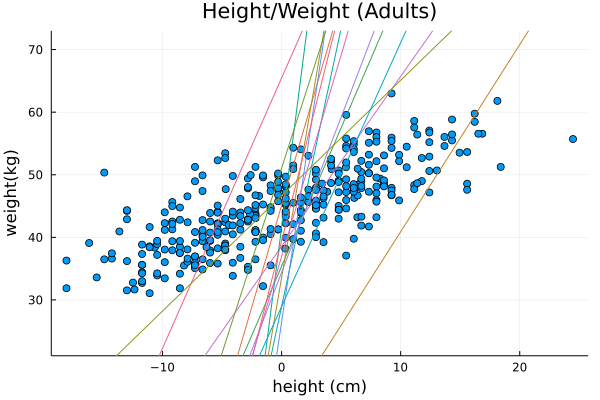

In [76]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm)", ylabel="weight(kg)", legend=false)
priors = [adults_height_weight_model(()) for _ in 1:15]
test_xs = range(minimum(adults.height), maximum(adults.height), length=1000)
plot!(test_xs, [f.(test_xs) for f in priors], legend=false)
plot!(ylim=(minimum(adults.weight) - 10, maximum(adults.weight) + 10))

In [77]:
observations = Gen.choicemap()
for (i,weight) in enumerate(adults.weight)
    observations[(:y, i)] = weight
end

num_samples=500
num_traces=100

traces = [Gen.importance_resampling(adults_height_weight_model, (adults.height,), observations, num_samples)[1] for _ in 1:num_traces]
as = Gen.get_value.(Gen.get_choices.(traces), :a)
bs = Gen.get_value.(Gen.get_choices.(traces), :b)
noises = Gen.get_value.(Gen.get_choices.(traces), :noise)
a = mean(as)
b = mean(bs)
noise = mean(noises);
a, b, noise

(44.805035865196814, 0.6056394821100954, 4.347197017599459)

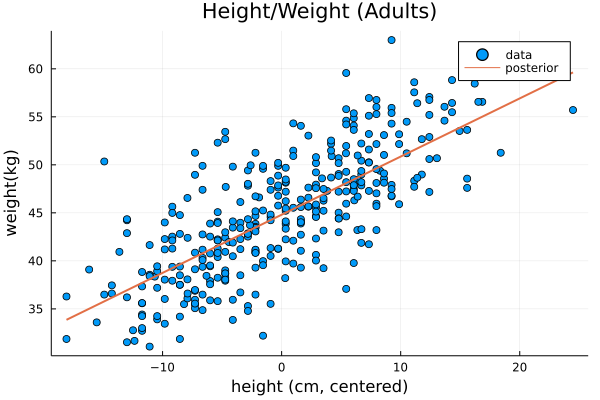

In [78]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", labels="data")
plot!(test_xs, (@. a + b * test_xs), linewidth=2., labels="posterior")

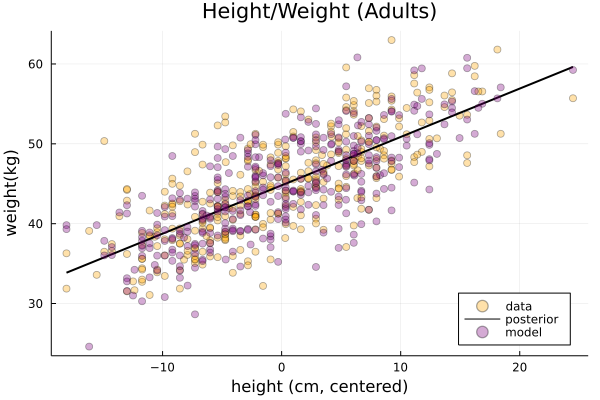

In [79]:
@df adults plot(:height, :weight, seriestype=:scatter, color=:orange, alpha=1/3, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", labels="data", legend=:bottomright)
plot!(test_xs, (@. a + b * test_xs), color=:black, labels="posterior", linewidth=2.)
predictions = @. rand(Normal(a + b * adults.height, noise))
plot!(adults.height, predictions, seriestype=:scatter, color=:purple, alpha=1/3, label="model")

In [82]:
to_predict = [140.,160.,175.]
StatsBase.transform!(dt, to_predict)

3-element Vector{Float64}:
 -14.597092613636335
   5.402907386363665
  20.402907386363665